In [11]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()

fname = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {fname}")


Saving IMDB Dataset.csv (1).zip to IMDB Dataset.csv (1) (1).zip
✅ Uploaded file: IMDB Dataset.csv (1) (1).zip


In [12]:

extract_folder = 'imdb_data'
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Files extracted:")
print(os.listdir(extract_folder))


Files extracted:
['IMDB Dataset.csv']


In [13]:
import pandas as pd

csv_path = os.path.join(extract_folder, 'IMDB Dataset.csv')  # update if filename differs
df = pd.read_csv(csv_path)

print("First 5 rows of dataset:")
display(df.head())


First 5 rows of dataset:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:

df = df.sample(n=1000, random_state=42).reset_index(drop=True)

print("Sampled 1000 reviews:")
display(df.head())

print("Total rows:", len(df))


Sampled 1000 reviews:


,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


Total rows: 1000


In [15]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

label_map = {'positive':1, 'negative':0}
df['label'] = df['sentiment'].str.strip().str.lower().map(label_map)

def preprocess_text(text):
    text = text.lower()                           # lowercase
    text = re.sub(r'<.*?>', ' ', text)           # remove HTML tags
    text = re.sub(r'[^a-z\s]', ' ', text)        # remove non-letter characters
    tokens = [w for w in text.split() if w not in ENGLISH_STOP_WORDS]  # remove stopwords
    return ' '.join(tokens)

df['clean'] = df['review'].astype(str).apply(preprocess_text)

print("Sample cleaned reviews:")
for i in range(3):
    print(df.loc[i,'clean'])


Sample cleaned reviews:
really liked summerslam look arena curtains just look overall interesting reason anyways best summerslam s wwf didn t lex luger main event yokozuna s time ok huge fat man vs strong man m glad times changed terrible main event just like match luger terrible matches card razor ramon vs ted dibiase steiner brothers vs heavenly bodies shawn michaels vs curt hening event shawn named big monster body guard diesel irs vs kid bret hart takes doink takes jerry lawler stuff harts lawler interesting ludvig borga destroyed marty jannetty undertaker took giant gonzalez terrible match smoking gunns tatanka took bam bam bigelow headshrinkers yokozuna defended world title lex luger match boring terrible ending deserves
television shows appeal quite different kinds fans like farscape does know youngsters years old fans male female different countries think just adore t v miniseries elements t v character driven drama australian soap opera episode science fact fiction hardiest tr

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean'].tolist())
y = df['label'].values

print("Feature matrix shape:", X.shape)


Feature matrix shape: (1000, 5000)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


Training samples: 800 Test samples: 200


In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train, y_train)
print("Model trained successfully!")


Model trained successfully!


Accuracy: 0.8050

              precision    recall  f1-score   support

    negative       0.82      0.80      0.81       105
    positive       0.79      0.81      0.80        95

    accuracy                           0.81       200
   macro avg       0.80      0.81      0.80       200
weighted avg       0.81      0.81      0.81       200



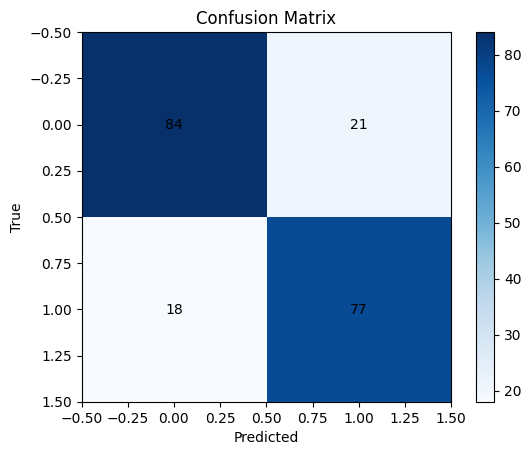

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.colorbar()
plt.show()


In [20]:
# Function to predict new reviews
def predict_review(text, vectorizer, model):
    clean = preprocess_text(text)
    X_new = vectorizer.transform([clean])
    proba = model.predict_proba(X_new)[0,1]
    label = 'positive' if proba >= 0.5 else 'negative'
    return label, float(proba)

# Test examples
examples = [
    "I absolutely loved this movie, it was amazing!",
    "This was the worst movie I have ever seen.",
    "Not good. I expected better."
]

for ex in examples:
    lbl, p = predict_review(ex, vectorizer, model)
    print(f"\nText: {ex}\nPrediction: {lbl} (prob={p:.3f})")



Text: I absolutely loved this movie, it was amazing!
Prediction: positive (prob=0.668)

Text: This was the worst movie I have ever seen.
Prediction: negative (prob=0.202)

Text: Not good. I expected better.
Prediction: negative (prob=0.487)
